### Max-Cut problem

Max-Cut es un problema de teoría de grafos que consiste en particionar un grafo separando los vértices en dos subconjuntos de manera tal que el número de aristas que contengan
un vértice de cada conjunto sea máximo. 

En este tutorial vamos a ver:
 - En qué consiste el problema del máximo corte.
 - Cómo formular Mux-Cut como un problema QUBO.
 - Resolver el Max-Cut utilizando el algoritmo QAOA.


Un grafo $G$ es un par ordenado $(V,E)$ donde $V$ es un conjunto de vértices y $E$ es un conjunto de aristas que unen esos vértices.

El siguiente es un ejemplo de grafo sobre el que vamos a trabajar para entender el problema Max-Cut.

Sea $V = \{A, B, C, D\}$ el conjunto de vértices y $E = \{(A, B), (B, C), (C, D), (D, A)\}$ el conjunto de aristas que unos esos vértices.

Visualicemos el grafo.

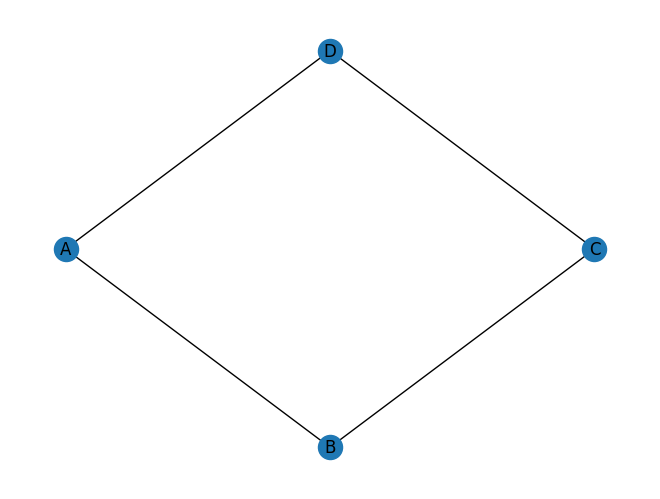

In [58]:
import matplotlib.pyplot as plt
import networkx as nx

graph = nx.Graph([("A", "B"), ("B", "C"), ("C", "D"), ("D", "A")])

nx.draw(graph,
        pos=nx.shell_layout(graph),
        with_labels=True)
plt.show()

Supongamos que hacemos la siguiente partición $V_1=\{A,B\}$ y $V_2=\{C,D\}$ y dibujemos el grafo con dos colores, rojo para $V_1$ y azul para $V_2$

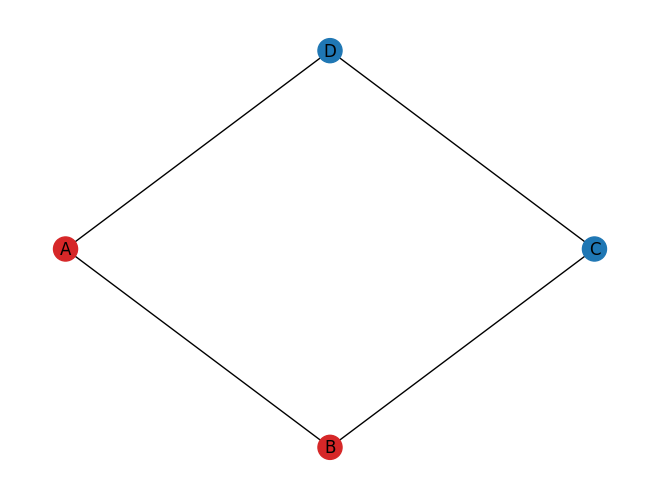

In [66]:
nx.draw(graph,
        pos=nx.shell_layout(graph),
        with_labels=True,
        node_color=["tab:red" if n in ("A", "B") else "tab:blue" for n in graph])

Contemos ahora las aristas que tienen un nodo en el subconjunto $V_1$ y otro en el subconjunto $V_2$. Podemos ver fácilmente que las aristas son $(A,D)$ y $(B,C)$, por lo tanto el corte es 2. ¿Es este el mayor número que podemos alcanzar o podemos particionar el grafo de otra manera que haga que el corte sea mayor?

La respuesta es si, podemos hacer otra partición del grafo de tal manera que el corte sea 4. ¿Cuá sería esta partición? Es fácil ver que seleccionando $V_1=\{A,C\}$ y $V_2=\{B,D\}$ las cuatro aristas tienen un nodo de cada conjunto y por lo tanto este es el corte máximo. Veámoslo usando la librería networkX.

In [76]:
from networkx.algorithms.approximation import maxcut

cut_value, partition = maxcut.one_exchange(graph, seed=42)

print(f"El máximo corte es {cut_value} y la partición es {partition}")

El máximo corte es 4 y la partición es ({'C', 'A'}, {'D', 'B'})


### Formulación QUBO

#### Under construction ...